Exécuter ce code pour importer toutes les données scrapées ci-dessous

In [1]:
import pickle,zlib,pandas as pd

player_stats_fbref=pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_1.bin','rb').read()))
player_stats_fbref.update(pickle.loads(zlib.decompress(open('fbref_data/compressed_player_stats_fbref_2.bin','rb').read())))
player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=False)


teams_fbref=pickle.load(open('fbref_data/teams_fbref.pkl','rb'))

glossary=pd.read_csv('fbref_data/Glossaire_FBREF.csv')


player_stats_tm=pd.read_csv('tm_data/player_stats_tm.csv')
player_stats_tm.index=player_stats_tm.loc[:,'Unnamed: 0']
player_stats_tm=player_stats_tm.drop('Unnamed: 0',axis=1)

transfer_history=pickle.load(open('tm_data/transfer_history.pkl','rb'))
player_ratings=pd.read_csv('sf_data/player_ratings.csv',index_col=0)


# Données FBREF

## Équipes 

Module pour Scrapper, (on peut aussi utiliser le module standard de python ie html_parser)

In [ ]:
!pip3 install lxml

In [241]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time

def get_teams_fbref(champ,season):
    
    #Code HTML de la page fbref de la saison season pour le championnat champ
    url=f'https://fbref.com/en/comps/{champ}/{season}-{season+1}/{season}-{season+1}-any-Stats'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    
    # Trouver le classement et toutes les lignes du tableau
    table=soup.find_all('table')[0]
    rows=table.find_all('tr')[1:]
    res={}
    
    #Faire un dicto avec toutes les équipes et leur id (utile pour après)
    for row in rows:
        link=row.find('a').get('href')
        id=link.split('/')[3]
        name=row.find('a').text
        res[name]=id
    return res

    

Trouver toutes les équipes pour tous les championnats sur les 10 dernières années

In [ ]:
championships={'GB1':9,'IT1':11,'ES1':12,'FR1':13,'L1':20}
years=[2024-i for i in range(10)]

seasons=[f'{n}-{n+1}' for n in [2024-i for i in range(10)]]

teams_fbref={}


for c in championships.keys():
    teams_fbref[c]={}
    for year in years:
        print(c,year)
        teams_fbref[c][year]=get_teams_fbref(championships[c],year)
        time.sleep(4)


In [49]:
teams_fbref['GB1'][2024]

{'Liverpool': '822bd0ba',
 'Chelsea': 'cff3d9bb',
 'Arsenal': '18bb7c10',
 "Nott'ham Forest": 'e4a775cb',
 'Manchester City': 'b8fd03ef',
 'Aston Villa': '8602292d',
 'Bournemouth': '4ba7cbea',
 'Fulham': 'fd962109',
 'Brighton': 'd07537b9',
 'Tottenham': '361ca564',
 'Brentford': 'cd051869',
 'Newcastle Utd': 'b2b47a98',
 'Manchester Utd': '19538871',
 'West Ham': '7c21e445',
 'Crystal Palace': '47c64c55',
 'Everton': 'd3fd31cc',
 'Leicester City': 'a2d435b3',
 'Ipswich Town': 'b74092de',
 'Wolves': '8cec06e1',
 'Southampton': '33c895d4'}

Sauvegarde du dictionnaire des équipes

In [425]:
import pickle
with open('teams_fbref.pkl','wb') as file: 
    pickle.dump(teams_fbref,file)

### Glossaire pour expliquer les acronymes des différentes stats

Obligé d'utiliser Selenium car présence d'un boutton

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time



#Sélecteurs de tous les bouttons

button_paths=['#stats_shooting_dom_lg_sh','#stats_passing_dom_lg_sh', \
              '#stats_passing_types_dom_lg_sh','#stats_gca_dom_lg_sh', \
                '#stats_playing_time_dom_lg_sh','#stats_possession_dom_lg_sh', '#stats_misc_dom_lg_sh']

button_paths=[button+f' > div > ul > li:nth-child({1 if button_paths.index(button)!=0 else 2}) > button' for button in button_paths]

#À titre d'exemple (on aurait pu prendre un autre joueur)

url=f'https://fbref.com/en/players/e06683ca/Virgil-van-Dijk'



driver=webdriver.Chrome()
driver.implicitly_wait(10)
driver.get(url)

glossaries=[]


for button in button_paths:
  
  # Scroller jusqu'au boutton glossaire, le code ajustera jusqu'à trouver le boutton par lui même
    while(True):
      try:
        driver.find_element(By.CSS_SELECTOR,button).click()
        break
      except:
        pass
    glossaries.append(([x.text for x in driver.find_elements(By.XPATH,'//*[@id="sr_glossary"]')]))
    

In [ ]:
glossary={}
for i in range(len(glossaries)):
    stats=[s.split('\n')[-1] for s in glossaries[i][0].split('--')][:-1 ]
    explanations=[s.split('\n')[0] for s in glossaries[i][0].split('--')][1:]
    stats=list(map(lambda s:s.strip(),stats))
    explanations=list(map(lambda s:s.split(':')[0].strip(),explanations))
    glossary.update(zip(stats,explanations))
    

Sauvegarde du glossaire

In [40]:
import pandas as pd 
glossary=pd.Series(glossary)
glossary.to_csv('Glossaire_FBREF.csv')

In [389]:
glossary.head(10)

Season                            Season
Age                  Age at season start
Country    Flag and name of the country.
Comp                         Competition
LgRank       Squad finish in competition
90s                           90s Played
Gls                                Goals
Sh                            GCA (Shot)
SoT                      Shots on Target
SoT%                   Shots on Target %
dtype: object

Stats des joueurs

In [71]:
def get_player_stats_fbref(player_id):
    "Retourne les statistiques pour le joueur d'id player_id sous format de dictionnaire"
    url=f'https://fbref.com/en/players/{player_id}/'
    html = requests.get(url).text
    time.sleep(4)
    soup = BeautifulSoup(html, 'lxml')
    res={}
    #Données sur taille poids pied fort âge et pays
    
    metadata=soup.find('div',id='meta')
    try:
        physical=list(map(lambda x:x.text,metadata.find_all('span')[1:3]))
        physical[0],physical[1]=float(physical[0].split('cm')[0]),float(physical[1].split('kg')[0])
    except:
        physical=['','']
    try:
        foot=metadata.find('strong',string='Footed:').next_sibling.strip()
    except:
        foot=''
    try:
        age=2025-int(metadata.find('span',id='necro-birth').get('data-birth').split('-')[0])
    except:
        age=''
    try:
        country=metadata.find('a').text
    except:
        country=''
    meta=physical+[foot,age,country]
    
    
    
    
    attributes=['height','weight','preferred foot','age','country']
    
    res['meta']=dict(zip(attributes,meta))
    
    
    
    
    
    std_rows=soup.find('table',id="stats_standard_dom_lg")
    
    try:
        std_rows=std_rows.select('tr[id="stats"]')
    except:
        return res
    
    
    # Données sur les antécédents en club, pays, championnats
    teams,countries,champs=[],[],[]
    for row in std_rows:
        teams.append(row.select_one(('td[data-stat="team"]')).text)
        countries.append((row.select_one(('td[data-stat="country"]'))).text.split(' ')[-1] )
        champs.append(row.select_one(('td[data-stat="comp_level"]')).text.split('1. ')[-1])
        
    # Extraction des stats sur tous les aspects du jeu
    
    
    #On différencie les Gardiens
    
    try:
        if soup.find(string='Position:').next_element[1]=='G':
            table_ids=["keeper","keeper","passing","passing_types","possession","playing_time","misc"]
        else:
            table_ids=["shooting","passing","passing_types","gca","defense","possession","playing_time","misc"]
    except:
        table_ids=["shooting","passing","passing_types","gca","defense","possession","playing_time","misc"]
    table_ids=list(map(lambda s:'stats_'+s+'_dom_lg',table_ids))
    
    
    
    for id in table_ids:
        
        
        #Certains joueurs n'ont pas des tableaux pour tous les aspects du jeu
        try:
            table=soup.find('table',id=id)
            header=table.find_all('tr')[1]
            cols=[x.get('data-stat') for x in header.find_all('th')][1:]
            for row in table.find_all('tr',id="stats"):
                year=row.select_one('th[data-stat="year_id"]').text
                if year not in res.keys():
                    res[year]={}
                for col in cols[:-1]:
                    res[year][col]=row.select_one(f'td[data-stat="{col}"]').text
        except:
            pass
        
    # Transformation en flottants pour les nombres
    for y in res.keys():
        
        for c in res[y].keys():
            try:
                #le replace pour les minutes qui ont une , au lieu de .
                res[y][c]=float(res[y][c].replace('-','.'))
            except:
                pass
    
    return res
        
    
def get_team_stats_fbref(team_id,season,champ,player_dict={},display_flag=False):
    url=f'https://fbref.com/en/squads/{team_id}/{season}-{season+1}/any'
    html = requests.get(url).text
    time.sleep(4)
    soup = BeautifulSoup(html, 'lxml')
    
    
    table=soup.find('table',id=f"stats_standard_{championships[champ]}").find('tbody')
    for row in table.find_all('tr'):
        name=row.find('a').text
        if name not in player_dict.keys():
            if display_flag:
                print(name)
            player_dict[name]=get_player_stats_fbref(row.find('a').get('href').split('/')[3])
    
    
    
    
    
    
    
    

In [ ]:
player_stats_fbref={}

#Seen pour relancer sans devoir reparcourir toutes les équipes si erreur
seen=set()
for country in teams_fbref.keys():
    for year in teams_fbref[country].keys():
        for team in teams_fbref[country][year].keys():
            if (team,year) not in seen:
                print(team,year)
                get_team_stats_fbref(teams_fbref[country][year][team],year,country,player_stats_fbref)
                seen.add((team,year))
                
                

Compression pour pouvoir mettre les données sur Github

In [420]:
import zlib
n=len(player_stats_fbref)

#Séparation en 2 pour respecter la limite des 25 Mb de Github
player_stats_fbref_1=dict(list(player_stats_fbref.items())[int(n/2):])
player_stats_fbref_2=dict(list(player_stats_fbref.items())[:int(n/2)])

compressed_player_stats_fbref_1=zlib.compress(pickle.dumps(player_stats_fbref_1))
compressed_player_stats_fbref_2=zlib.compress(pickle.dumps(player_stats_fbref_2))


with open('compressed_player_stats_fbref_1.bin', 'wb') as f:
    f.write(compressed_player_stats_fbref_1)
with open('compressed_player_stats_fbref_2.bin', 'wb') as f:
    f.write(compressed_player_stats_fbref_2)



In [3]:


with open('compressed_player_stats_fbref_1.bin', 'rb') as f:
    compressed_player_stats_fbref_1=f.read()
with open('compressed_player_stats_fbref_2.bin', 'rb') as f:
    compressed_player_stats_fbref_2=f.read()


#Pour être sur que la compression s'est bien passée
player_stats_fbref=pickle.loads(zlib.decompress(compressed_player_stats_fbref_1))
player_stats_fbref.update(pickle.loads(zlib.decompress(compressed_player_stats_fbref_2)))

In [27]:
# Sauvegarde au format csv

player_stats_fbref=pd.DataFrame(player_stats_fbref).transpose()
player_stats_fbref=player_stats_fbref.sort_index(axis=1,ascending=True)

In [50]:
player_stats_fbref.head()

,meta,2024-2025,2024,2023-2024,2023,2022-2023,2022,2021-2022,2021,2020-2021,...,1999-2000,1999,1998-1999,1998,1997-1998,1996-1997,1995-1996,1994-1995,1993-1994,1992-1993
César Fernández,"{'height': '', 'weight': '', 'preferred foot':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yoel Lago,"{'height': '', 'weight': '', 'preferred foot':...","{'age': 20.0, 'team': 'Celta Vigo', 'country':...",NaN,"{'age': 19.0, 'team': 'Celta Vigo', 'country':...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marc Vidal,"{'height': '', 'weight': '', 'preferred foot':...","{'age': 24.0, 'team': 'Celta Vigo', 'country':...",NaN,NaN,NaN,"{'age': 22.0, 'team': 'FC Andorra', 'country':...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rui Silva,"{'height': 189.0, 'weight': 84.0, 'preferred f...","{'age': 30.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 29.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 28.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 27.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 26.0, 'team': 'Granada', 'country': 'e...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abde Ezzalzouli,"{'height': 177.0, 'weight': 73.0, 'preferred f...","{'age': 22.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 21.0, 'team': 'Betis', 'country': 'es ...",NaN,"{'age': 20.0, 'team': 'Osasuna', 'country': 'e...",NaN,"{'age': 19.0, 'team': 'Barcelona', 'country': ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
player_stats_fbref

[('age', 32.0),
 ('team', 'Liverpool'),
 ('country', 'eng ENG'),
 ('comp_level', '1. Premier League'),
 ('lg_finish', '1st'),
 ('minutes_90s', 13.6),
 ('goals', 13.0),
 ('shots', 43.0),
 ('shots_on_target', 23.0),
 ('shots_on_target_pct', 53.5)]

## Aggrégation pour avoir des données globales sur les équipes

### Afin de faire cela, on ne va pas scrapper les données pour chaque équipe, cela nous demanderais de patienter une nouvelle heure. On va plutôt savoir quelle fonction d'aggrégation on doit appliquer sur l'ensemble des joueurs sur une entrée pour chaque statistique (ie max,min, somme...) en prenant une entrée particulière, ici Liverpool en 2024-2025, et on va utiliser cette fonction d'aggrégation pour toutes les entrées (ie équipe/saison) afin de créer une base de données avec les données des équipes.

### Extraction des statistiques globales de Liverpool en 2024-2025 (pour 'fit')

In [49]:


def get_global_team_stats_fbref(team_id,season):
    "Remplis aggregation_dict avec les différentes statistiques et la fonction d'aggrégation pour chaque"
    html=requests.get(f'https://fbref.com/en/squads/{team_id}/{season}/team-Stats').text
    soup=BeautifulSoup(html,'lxml')
    time.sleep(4)
    
    #Tableaux avec des statistiques détaillées
    tables=soup.find_all('table')[2:-2]


    res={}

    for table in tables:
        
        
        
        # Ligne d'aggrégation (Squad total)
        row=table.find('tfoot').find('tr')
        
        for col in row.find_all('td'):
            stat_name=col.get('data-stat')
            
            # Celles qui sont disponibles
            
            try:
                res[stat_name]=float(col.text.replace(',',''))
            except:
                continue
            
    
            
            
    return res
            
            
get_global_team_stats_fbref('53a2f082','2024-2025')     
        
    


{'age': 27.5,
 'gk_games': 18.0,
 'gk_games_starts': 18.0,
 'gk_minutes': 1620.0,
 'minutes_90s': 18.0,
 'gk_goals_against': 18.0,
 'gk_goals_against_per90': 1.0,
 'gk_shots_on_target_against': 51.0,
 'gk_saves': 34.0,
 'gk_save_pct': 64.7,
 'gk_wins': 12.0,
 'gk_ties': 4.0,
 'gk_losses': 2.0,
 'gk_clean_sheets': 8.0,
 'gk_clean_sheets_pct': 44.4,
 'gk_pens_att': 0.0,
 'gk_pens_allowed': 0.0,
 'gk_pens_saved': 0.0,
 'gk_pens_missed': 0.0,
 'gk_free_kick_goals_against': 0.0,
 'gk_corner_kick_goals_against': 2.0,
 'gk_own_goals_against': 1.0,
 'gk_psxg': 15.5,
 'gk_psnpxg_per_shot_on_target_against': 0.31,
 'gk_psxg_net': -1.5,
 'gk_psxg_net_per90': -0.08,
 'gk_passes_completed_launched': 37.0,
 'gk_passes_launched': 125.0,
 'gk_passes_pct_launched': 29.6,
 'gk_passes': 537.0,
 'gk_passes_throws': 98.0,
 'gk_pct_passes_launched': 17.5,
 'gk_goal_kicks': 134.0,
 'gk_pct_goal_kicks_launched': 23.1,
 'gk_goal_kick_length_avg': 28.9,
 'gk_crosses': 202.0,
 'gk_crosses_stopped': 11.0,
 'gk_cr

In [51]:
global_team_stats_fbref={}

seen=set()
for champ,year,team in tqdm([(champ,year,team) for champ in teams_fbref.keys() for year in teams_fbref[champ].keys() for team in teams_fbref[champ][year].keys()]):
            if (champ,year,team) not in seen:
                if team not in global_team_stats_fbref.keys():
                    global_team_stats_fbref[team]={}
                    
                d=get_global_team_stats_fbref(teams_fbref[champ][year][team],f'{year}-{year+1}')
                if d=={}:
                    print(f'No result for : {team} at year {year}')
                global_team_stats_fbref[team][year]=d
                seen.add((champ,year,team))
                
                

100%|██████████| 976/976 [1:44:54<00:00,  6.45s/it]


In [57]:
pickle.dump(global_team_stats_fbref,open('global_team_stats_fbref.pkl','wb'))

In [61]:
global_team_stats_fbref=pd.DataFrame(global_team_stats_fbref)
global_team_stats_fbref=global_team_stats_fbref.transpose()
global_team_stats_fbref.head()

,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015
Liverpool,"{'age': 27.5, 'gk_games': 17.0, 'gk_games_star...","{'age': 26.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.2, 'gk_games': 38.0, 'gk_games_star..."
Chelsea,"{'age': 24.0, 'gk_games': 18.0, 'gk_games_star...","{'age': 24.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.5, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.3, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star..."
Arsenal,"{'age': 26.4, 'gk_games': 17.0, 'gk_games_star...","{'age': 25.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 24.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 24.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 25.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.8, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.0, 'gk_games': 38.0, 'gk_games_star..."
Nott'ham Forest,"{'age': 26.9, 'gk_games': 18.0, 'gk_games_star...","{'age': 25.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.5, 'gk_games': 38.0, 'gk_games_star...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manchester City,"{'age': 27.7, 'gk_games': 18.0, 'gk_games_star...","{'age': 26.6, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.2, 'gk_games': 38.0, 'gk_games_star...","{'age': 27.0, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.1, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.9, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.7, 'gk_games': 38.0, 'gk_games_star...","{'age': 26.4, 'gk_games': 38.0, 'gk_games_star...","{'age': 28.5, 'gk_games': 38.0, 'gk_games_star...","{'age': 28.3, 'gk_games': 38.0, 'gk_games_star..."


In [63]:
global_team_stats_fbref.columns=list(map(lambda s:f'{s}-{s+1}',global_team_stats_fbref.columns))

In [ ]:
!mkdir fbref_data
!mv compressed_player_stats_fbref_1.bin compressed_player_stats_fbref_2.bin Glossaire FBREF Glossaire_FBREF.csv teams_fbref.pkl fbref_data


# Données Transfermarkt

## Données sur les joueurs

###  (On récupère évolution de la valeur marchande + postes)

In [ ]:
#Si nécessaire
!pip3 install rapidfuzz

Pour rapidement vérifier si un joueur a ses statistiques définies pour une certaine saison

In [7]:
na_player_stats_fbref=player_stats_fbref.isna()

Pour accéder rapidement à la liste des équipes

In [49]:

teams_fbref_list=[]
for k,v in teams_fbref.items():
    for kk,vv in v.items():
        teams_fbref_list+=(list(vv.keys()))

In [50]:
teams_fbref_list[:10]

['Liverpool',
 'Chelsea',
 'Arsenal',
 "Nott'ham Forest",
 'Manchester City',
 'Aston Villa',
 'Bournemouth',
 'Fulham',
 'Brighton',
 'Tottenham']

In [312]:
import time
from rapidfuzz.distance import Levenshtein
#Header pout ne pas se faire bloquer l'accès par le site
heads = {'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36'}

def get_player_stats_tm(player_id):
    "Retourne un dictionnaire avec la valeur marchande et les postes joués par le joueur d'id player_id"
    
    url=f'https://www.transfermarkt.com/konstantinos-tsimikas/profil/spieler/{player_id}'
    
    
    html = requests.get(url,headers=heads).text
    time.sleep(1)
    soup = BeautifulSoup(html, 'lxml')
    
    # Extraction des positions
    position_box=soup.find('div',class_='detail-position__box')
    try:
        positions=position_box.find_all('dd',class_='detail-position__position')
        positions=[position.text for position in positions]
    except:
        positions=[]
    
    
    
    # Extraction de l'histoirique de la valeur marchande (accessible à travers un endpoint)
    
    
    value_graph=requests.get(f'https://transfermarkt.com/ceapi/marketValueDevelopment/graph/{player_id}',headers=heads)
    time.sleep(1)
    value_graph=value_graph.json()
    value_graph_values=[d['mw'] for d in value_graph['list']]
    
    value_graph_values=[float(v[1:-1])*(1000 if v[-1]=='m' else 1) if v!='-' else 0. for v in value_graph_values ]
    value_graph_years=[d['datum_mw'].split(' ')[-1] for d in value_graph['list']]
    value_graph={value_graph_years[i]:value_graph_values[i] for i in range(len(value_graph_years))}
    return {'positions':positions,'market_values':value_graph}
    



def get_team_stats_tm(url,season,team,player_dict={},display_flag=False):
    "Remplis player_dict avec les statisiques obtenues avec get_players_stats_tm de tous les joueurs de team lors de season"
    
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    
    
    
    
    table=soup.find('div',id='yw1')
    table=table.find('tbody')
    rows=table.select('td.hauptlink:not(.rechts)')
    player_list=[]
    
    # Pour trouver l'équipe du joueur correspondante dans la bd de fbref
    team_tm=min([(Levenshtein.distance(team,team_fbref),team_fbref) for team_fbref in teams_fbref_list])[1]
    
    
    #Extraction de la bd des joueurs de l'équipe team_tm lors de season dans fbref
    
    # Pas forcément nécessaire mais pour considérer les cas où la saison est au format année ( en Amérique du Sud nottament) ou année - année + 1 (cas usuel en Europe)
    team_fbref_1=[player for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,str(season)]) and player_stats_fbref.loc[player,str(season)]['team']==team_tm]
    team_fbref_2=[player for player in player_stats_fbref.index if not(na_player_stats_fbref.loc[player,str(season)+'-'+str(season+1)]) and player_stats_fbref.loc[player,str(season)+'-'+str(season+1)]['team']==team_tm]
    if len(team_fbref_2)>=len(team_fbref_1):
        season=str(season)+'-'+str(season+1)
        team_fbref=team_fbref_2
    else:
        season=str(season) 
        team_fbref=team_fbref_1
        
    # Pour chaque joueur on trouve le joueur correspondant dans la bd fbref
    for row in rows:
        name_tm=row.find('a').text.strip()
        score,name=min([(Levenshtein.distance(player,name_tm),player) for player in team_fbref])
        player_list.append((score,name,row.find('a').get('href')))
    
    
    # On priorise les joueurs qui ont probablement un match dans la bd fbref
    # (si la distance de Levenshtein est grande pour tous les joueurs à priori ce joueur n'est pas dans la bd fbref)
    player_list=sorted(player_list)
    player_list=player_list[:len(team_fbref)]
    for score,name,link in player_list:
        
        #Pour éviter les redondances
        if name not in player_dict.keys():
            if display_flag:
                print(name)
            player_dict[name]=get_player_stats_tm(link.split('/')[-1])
    
    
        
    



def get_champ_stats_tm(season,champ,player_dict={},display_flag=False):
    "Remplis player_dict les statistiques obtenues lors de get_team_stats_tm pour toutes les équipes de champ lors de season"
    url=f'https://www.transfermarkt.com/premier-league/startseite/wettbewerb/{champ}/plus/?saison_id={season}'
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    table=soup.find('div',id='yw1')
    
    table=table.find('tbody')
    rows=table.find_all('tr')
    for row in rows:
        team_url=row.find('a').get('href')
        team=row.find('a').get('title')
        if display_flag:
            print(team)
        get_team_stats_tm('https://www.transfermarkt.com'+team_url,season,team,player_dict,False)
            

        
        
        
        
        
        
        
        


In [ ]:
#player_stats_tm={}
#Seen pour relancer sans devoir reparcourir toutes les équipes si erreur
#seen=set()
for country in championships.keys():
    for year in years:
            if (country,year) not in seen:
                print(country,year)
                #Enlever display flag si besoin
                get_champ_stats_tm(year,country,player_stats_tm,display_flag=True)
                seen.add((country,year))
                
                

Sauvegarde des données

In [320]:
pickle.dump(player_stats_tm,open('player_stats_tm.pkl','wb'))

In [323]:
player_stats_tm_dict=player_stats_tm
player_stats_tm=pd.DataFrame(player_stats_tm).transpose()
player_stats_tm.to_csv('player_stats_tm.csv',index=False)

In [212]:
for player in player_stats_tm_dict.keys():
    player_stats_fbref.loc[player,'meta'].update({'positions':player_stats_tm_dict[player]['positions'],'market_values':player_stats_tm_dict[player]['market_values']})
    
player_stats_tm.to_csv('player_stats_tm.csv',index=False)

In [59]:
player_stats_tm.head()

,positions,market_values
Unnamed: 0,,
Bernardo Silva,"['Attacking Midfield', 'Right Winger', 'Centra...","{'2013': 600.0, '2014': 2500.0, '2015': 15000...."
Ederson,['Goalkeeper'],"{'2013': 300.0, '2014': 900.0, '2015': 1200.0,..."
Erling Haaland,['Centre-Forward'],"{'2016': 200.0, '2017': 300.0, '2018': 5000.0,..."
Jack Grealish,"['Left Winger', 'Attacking Midfield', 'Left Mi...","{'2013': 250.0, '2014': 1000.0, '2015': 4500.0..."
John Stones,"['Centre-Back', 'Right-Back', 'Defensive Midfi...","{'2011': 50.0, '2012': 100.0, '2013': 3500.0, ..."


## Extraction des historiques de transfert pour chaque équipe

In [426]:
def get_team_transfers(url,team,season,champ,transfer_dict={}):
    "Remplis transfer_dict avec tous les transferts entrants et sortants pour team lors de season"
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    
    
    
    arrivals_tab=soup.find('div',id='yw1').find('tbody').find_all('tr',{'class':['even','odd']})
    departures_tab=soup.find('div',id='yw2').find('tbody').find_all('tr',{'class':['even','odd']})
    arrivals,departures=[],[]
    
    #Utiles pour calculer le déficit/budget d'un club
    spent,sell=0,0
    
    
    for type in [arrivals_tab,departures_tab]:
        for transfer in type:
            links=transfer.find_all('a')
            name,club,fee=links[0].text,links[1].get('title'),links[-1].text
            #Différencier transfert monétaire et autres (prêts, transferts gratuits...)
            if fee[-1] in ['k','m']:
                fee=float(fee[fee.index('€')+1:-1])*(1000 if fee[-1]=='m' else 1)
                if type==arrivals_tab:
                    spent+=fee
                else:
                    sell+=fee
            (arrivals if type==arrivals_tab else departures).append([name,club,fee])
        
    for type in [arrivals,departures]:
        for name,club,fee in type:
            
            #On cherche les équivalents dans la bd fbref 
            
            #Pour les retraités, ceux qui arrêtent le foot
            if club== None:
                club_fbref=None
            else:
                club_fbref=min([(Levenshtein.distance(club,club_f),club_f) for club_f in teams_fbref_list])[1]
            
            name_fbref=min([(Levenshtein.distance(name,name_f),name_f) for name_f in player_stats_fbref.index])[1]
            type.remove([name,club,fee])
            type.append([name_fbref,club_fbref,fee])
    transfer_dict[champ][season][team]={'arrivals':arrivals,'departures':departures,'spent':spent,'sell':sell}

    
def get_champ_transfers(champ,season,transfer_dict={},display_flag=False):
    "Remplis transfer_dict avec tous les transferts entrants et sortants de champ lors de season"
    # On applique simplement la fonction précédente sur un championnat entier
    url=f'https://www.transfermarkt.com/any/startseite/wettbewerb/{champ}/plus/?saison_id={season}'
    html=requests.get(url,headers=heads).text
    time.sleep(1)
    soup=BeautifulSoup(html,'lxml')
    rows=soup.find('div',id='yw1').find('tbody').find_all('tr',{'class':["odd","even"]})
    for row in rows:
        team_id=row.find('a').get('href').split('/')[4]
        team_url=f'https://www.transfermarkt.com/any/transfers/verein/{team_id}/saison_id/{season}'
        team_name=row.find('a').get('title')
        if display_flag:
            print(team_name)
        get_team_transfers(team_url,team_name,season,champ,transfer_dict)
        
        
    
    
        
    

In [ ]:
transfer_history={}
seen=set()
for c in teams_fbref.keys():
    transfer_history[c]=transfer_history.get(c,{})
    for y in teams_fbref[c].keys():
        if (c,y) not in seen:
            print(c,y)
            transfer_history[c][y]={}
            get_champ_transfers(c,y,transfer_history)
            seen.add((c,y))
        
            
            
            

In [431]:
pickle.dump(transfer_history,open('transfer_history.pkl','wb'))

on peut vérifier sur transfermrkt que cela correspond bien

In [65]:
transfer_history['GB1'][2024]['Liverpool FC']

{'arrivals': [['Federico Chiesa', 'Juventus FC', 12000.0],
  ['Vitezslav Jaros', 'Liverpool FC U21', '-'],
  ['Sepp van den Berg', '1.FSV Mainz 05', 'End of loanJun 30, 2024'],
  ['Calvin Ramsay', 'Wigan Athletic', 'End of loanMay 31, 2025'],
  ['Rhys Williams', 'Morecambe FC', 'End of loanJan 1, 2025'],
  ['Marcelo Pitaluga', 'Livingston FC', 'End of loanMay 31, 2025'],
  ['Tyler Morton', 'Liverpool', '-'],
  ['Ben Doak', 'Middlesbrough', 'End of loanMay 31, 2025'],
  ['Marcelo Pitaluga', 'St. Pauli', 'End of loanJun 30, 2024'],
  ['Fabio Carvalho', 'Hull City', 'End of loanJun 30, 2024'],
  ['Giorgi Mamardashvili', 'Valencia', 30000.0],
  ['Matt Phillips', 'Dortmund', 'End of loanMay 31, 2025']],
 'departures': [['Fábio Carvalho', 'Brentford FC', 23400.0],
  ['Giorgi Mamardashvili', 'Valencia CF', 'loan transfer'],
  ['Ben Doak', 'Middlesbrough FC', 'loan transfer'],
  ['Nat Phillips', 'Derby County', 'loan transfer'],
  ['Marcelo Pitaluga', 'Livingston FC', 'loan transfer'],
  ['Joe

In [ ]:
def get_global_team_stats_tm()

In [433]:
#!mkdir tm_data
!mv player_stats_tm.csv player_stats_tm.pkl transfer_history.pkl tm_data

## Importation des évaluations de joueurs sur SofaScore

#### À travers toute cette section on fait appel à l'api de sofascore accessible directement en entrant l'url avec les bonnes options dans la barre de recherche

#### Extraction des ids utiles pour utiliser l'API

In [94]:



BASE_URL = "https://api.sofascore.com/api/v1"

def get_champs_sf(language="en", sport="football"):
    "Obtenir la liste des ids des différents championnats de football sur sofascore"
    url = f"{BASE_URL}/config/unique-tournaments/{language}/{sport}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["uniqueTournaments"]

def get_seasons_sf(tournament_id):
    "Obtenir la liste des ids des différentes saisons pour les différents championnats sur sofascore"
    url = f"{BASE_URL}/unique-tournament/{tournament_id}/seasons"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["seasons"]



championships = get_champs_sf()

championships=dict([(champ['name'],champ['id']) for champ in championships if champ['name'] in ['Premier League','Ligue 1','LaLiga','Serie A','Bundesliga']])

championships


{'Premier League': 17,
 'LaLiga': 8,
 'Bundesliga': 35,
 'Serie A': 23,
 'Ligue 1': 34}

In [79]:
seasons_sf={}
for c in championships.keys():
    seasons_sf[c]={}
    seasons_tab=get_seasons_sf(championships[c])
    for i in range(10):
        seasons_sf[c][2024-i]=seasons_tab[i]['id']

In [81]:
seasons_sf['Premier League']

{2024: 61627,
 2023: 52186,
 2022: 41886,
 2021: 37036,
 2020: 29415,
 2019: 23776,
 2018: 17359,
 2017: 13380,
 2016: 11733,
 2015: 10356}

In [90]:

def get_team_ids_sf(tournament_id,season_id):
    "Obtenir la liste des ids de toutes les équipes participant au tournoi d'id tournament_id durant la saison dont l'id est season_id"
    url = f"https://api.sofascore.com/api/v1/unique-tournament/{tournament_id}/season/{season_id}/teams"
    response = requests.get(url)
    response.raise_for_status()  
    data = response.json()
    return dict([(team['name'],team['id']) for team in data['teams']])

In [ ]:
team_ids_sf={}
for c in seasons_sf.keys():
    team_ids_sf[c]={}
    for y in seasons_sf[c].keys():
        team_ids_sf[c][y]=get_team_ids_sf(championships[c],seasons_sf[c][y])



In [109]:
team_ids_sf['Premier League'][2022]

{'Arsenal': 42,
 'Leicester City': 31,
 'Brighton & Hove Albion': 30,
 'Leeds United': 34,
 'Brentford': 50,
 'Aston Villa': 40,
 'Bournemouth': 60,
 'Nottingham Forest': 14,
 'Wolverhampton': 3,
 'Manchester City': 17,
 'Fulham': 43,
 'West Ham United': 37,
 'Crystal Palace': 7,
 'Tottenham Hotspur': 33,
 'Manchester United': 35,
 'Southampton': 45,
 'Chelsea': 38,
 'Everton': 48,
 'Newcastle United': 39,
 'Liverpool': 44}

#### Extraction des évaluations de tous les joueurs

In [156]:
def get_team_ratings(team_id,season_id,champ_id):
    "Renvoie un dictionnaire avec comme clés les joueurs de l'équipe associée à team_id et comme valeurs leur notes pour la saison spécifiée"
    url=f'https://www.sofascore.com/api/v1/team/{team_id}/unique-tournament/{champ_id}/season/{season_id}/top-players/overall'  
    response=requests.get(url)
    data=response.json()
    try:
        data=data['topPlayers']['rating']
    except:
        print(f'No data for {team_id}')
        return {}
    
    ratings={}
    for entry in data:
        name=entry['player']['name']
        name=min([(Levenshtein.distance(name,name_f),name_f) for name_f in player_stats_fbref.index])[1]
        ratings[name]=entry['statistics']['rating']
    return ratings
    



In [ ]:
#décommenter pour pouvoir exécuter le code

#player_ratings={}
#seen=set()
for c,c_id in championships.items():
    for y,y_id in seasons[c].items():
        for team,team_id in team_ids_sf[c][y].items():
            if (c,y,team) not in seen:
                print(y,team)
                for player,rating in get_team_ratings(team_id,y_id,c_id).items():
                    if player in player_ratings.keys():
                        player_ratings[player][y]=rating
                    else:
                        player_ratings[player]={y:rating}
                seen.add((c,y,team))
                    

In [103]:
team_ids_sf['Serie A'][2024]

{'Hellas Verona': 2701,
 'Genoa': 2713,
 'Empoli': 2705,
 'Torino': 2696,
 'Venezia': 2688,
 'Milan': 2692,
 'Juventus': 2687,
 'Udinese': 2695,
 'Lazio': 2699,
 'Inter': 2697,
 'Bologna': 2685,
 'Fiorentina': 2693,
 'Napoli': 2714,
 'Monza': 2729,
 'Parma': 2690,
 'Atalanta': 2686,
 'Como': 2704,
 'Roma': 2702,
 'Cagliari': 2719,
 'Lecce': 2689}

In [595]:
player_ratings=pd.DataFrame(player_ratings).transpose()
player_ratings.columns=list(map(lambda n:f'{n}-{n+1}',player_ratings.columns))
player_ratings.to_csv('player_ratings.csv')

In [594]:
player_ratings.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Bukayo Saka,8.04,7.36,5.97,7.67,6.43,6.04,6.25,NaN,NaN,NaN
Neto,9.41,7.31,4.00,7.71,7.09,6.52,8.29,7.84,8.20,8.0
Declan Rice,8.63,7.98,5.95,8.14,6.30,7.03,7.95,7.26,NaN,NaN
Gabriel Magalhães,6.70,7.86,6.00,6.66,5.56,6.68,6.00,7.12,5.89,NaN
Martin Ødegaard,6.95,7.14,8.25,8.36,5.79,6.51,NaN,NaN,NaN,NaN


In [596]:
!mkdir sf_data
!mv player_ratings.csv sf_data

In [41]:
len(player_ratings)

7619

On voit qu'on a 3000 joueurs qui n'ont aucune évaluation définie, on peut donc faire un modèle qui fait cette évaluation

# Modèle:Outil d'évaluation de performance des joueurs selon leurs métriques

## Input:Vectorisation des données des joueurs

Petit réglage sur les minutes jouées qui n'ont pas pu être interprétées comme des float à cause de ','

In [5]:
def change_minutes_type(entry):
    "Numérise l'entrée associée au minutes jouées"
    try:
        entry['minutes']=float(entry['minutes'].replace(',',''))
        return entry
    except:
        return entry



player_stats_fbref=player_stats_fbref.map(change_minutes_type)

### Encodage des variables catégoriques

Module utile pour avoir immédiatement un encodage binaire des variables catégorique 

In [4]:
!pip3 install category_encoders


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Les variables à encoder

In [5]:
[(k,v) for (k,v) in player_stats_fbref.loc['Mohamed Salah','2024-2025'].items() if type(v)==str and v!='']

[('team', 'Liverpool'),
 ('country', 'eng ENG'),
 ('comp_level', '1. Premier League'),
 ('lg_finish', '1st')]

Encodage Binaire pour ne pas avoir de relation d'ordre mais ne pas utiliser trop de mémoire non plus

In [8]:
import category_encoders as ce

encoded_var=['team','country','comp_level','lg_finish']

encoding_table={}

for var in encoded_var:
    
    
    encoder=ce.BinaryEncoder(return_df=False)
    
    
    #extraction des valeurs que peut prendre var
    classes=set()
    years=[f'{2024-i}-{2024-i+1}' for i in range(10)]
    for year in years:
        for player in player_stats_fbref.index:
            if not(na_player_stats_fbref.loc[player,year]):
                classes.add(player_stats_fbref.loc[player,year][var])
    encoder.fit(list(classes))
    
    encoding_table[var]=encoder

In [9]:
encoding_table['country'].transform(['eng ENG'])

array([[0, 0, 1, 0, 0, 0]])

### Extraction de la moyenne et de l'écart type pour les variables non catégoriques afin de normaliser

$\textbf{C'est très important car sinon la loss diverge}$

In [12]:
import numpy as np
#Pour fixer la taille de l'input
categories=player_stats_fbref.loc['Mohamed Salah','2024-2025'].keys()

norm_dict={}

# Calculer la moyenne et l'écart-type pour toutes les statistiques
for category in categories:
    if category not in encoded_var:
        data=[player_stats_fbref.loc[player,year][category] for player in player_stats_fbref.index for year in seasons if not(na_player_stats_fbref.loc[player,year]) and category in player_stats_fbref.loc[player,year].keys()]
        data=np.array(list(filter(lambda x: type(x)==float,data)))
        mean,std=np.mean(data),np.std(data)
        norm_dict[category]={'mean':mean,'std':std}
        
def normalise(x):
    "normalise les différentes entrées du dictionnaire x"
    for category in categories:
        if category not in encoded_var and type(x)==dict and category in x.keys() and type(x[category])==float:
            mean,std=norm_dict[category]['mean'],norm_dict[category]['std']
            x[category]=(x[category]-mean)/std  
    return x  


        
            

In [13]:
#données normalisées
player_stats_fbref_norm=player_stats_fbref.apply(lambda x:x.apply(normalise))

In [14]:
player_stats_fbref_norm.loc['Mohamed Salah','2024-2025']['goals'],player_stats_fbref.loc['Mohamed Salah','2024-2025']['goals']

(2.9445369988223056, 2.9445369988223056)

On voit bien que l'échelle est réduite

In [15]:

def vectorize(player,season):
    "Retourne le vecteur encodant la saison season de player"
    data=player_stats_fbref_norm.loc[player,season]
    vect=[]
    for category in categories:
            if category in data.keys() and data[category]!='':
                if category in encoded_var:
                    vect+=list(encoding_table[category].transform([data[category]])[0])
                else:
                    vect+=[data[category]]
            else:
                # l'encodage binaire fait qu'on remplace une information catégorique inconnue par un vecteur de bonne taille avec que des -1
                vect+=[-1]*(1 if category not in encoded_var else len(list(encoding_table[category].transform([player_stats_fbref_norm.loc['Mohamed Salah','2024-2025'][category]])[0])))
            
    return vect


input_size=len(vectorize('Mohamed Salah','2024-2025')) 
vectorize('Mohamed Salah','2024-2025')[:10]

[1.516432869569389, 0, 0, 1, 1, 1, 1, 1, 1, 1]

## Définition du modèle

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

model=nn.Linear(input_size,1)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)



In [22]:
import numpy as np
n=len(player_ratings)
random_indexes=np.random.choice(np.arange(n),int(0.8*n),replace=False)

#On sépare bien les données en données d'entraînement et données test

training_data=player_ratings.iloc[random_indexes]
validation_data=player_ratings.iloc[[i for i in np.arange(n) if i not in random_indexes]]

In [23]:
training_data.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Nikola Milenković,6.84,5.51,5.63,7.92,7.87,6.37,7.31,5.58,NaN,NaN
Odisseas Vlachodimos,NaN,7.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.89
Laurent Ciman,NaN,NaN,NaN,NaN,NaN,NaN,7.37,NaN,NaN,NaN
Darren Randolph,NaN,NaN,NaN,NaN,6.35,7.62,NaN,NaN,7.90,5.88
Tom Carroll,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.96,7.94,7.80


In [24]:
validation_data.head()

,2024-2025,2023-2024,2022-2023,2021-2022,2020-2021,2019-2020,2018-2019,2017-2018,2016-2017,2015-2016
Martin Ødegaard,6.95,7.14,8.25,8.36,5.79,6.51,NaN,NaN,NaN,NaN
David Raya,6.69,7.85,7.85,7.25,NaN,NaN,NaN,NaN,NaN,NaN
Ben White,5.72,5.82,7.56,7.07,6.15,NaN,NaN,NaN,NaN,NaN
Leandro Trossard,6.58,6.57,6.00,7.40,7.65,5.82,NaN,NaN,NaN,NaN
Mikel Merino,6.84,7.90,7.78,8.02,5.70,5.72,6.24,6.59,6.53,NaN


In [25]:
na_validation_data=validation_data.isna()
na_training_data=training_data.isna()

## Entraînement

In [26]:
loss_tab_training=[]



from tqdm import tqdm

# on itère 10 fois sur les données d'entrainement
for epoch in tqdm(range(10)):

    for player in training_data.index:
        current_loss=[]
        for season in training_data.columns:
            if not(na_training_data.loc[player,season]) and not(na_player_stats_fbref.loc[player,season]):
                

                    input=torch.Tensor(vectorize(player,season))
                    output=torch.Tensor([training_data.loc[player,season]])
                    
                    # Écart entre la note attendue (réelle) et celle prédite par le modèle
                    prediction=model(input)
                    loss=criterion(output,prediction)
                    
                    current_loss.append(loss)
                    
                    #Descente de gradient sur les paramètres du modèle
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        if current_loss!=[]:
            loss_tab_training.append(np.average(list(map(lambda x:x.item(),current_loss))))
                
                
                

100%|██████████| 10/10 [09:39<00:00, 57.94s/it]


On découpe le tableau en 100 et on fais affiche la moyenne des 100 sous-tableaux afin d'avoir un graphique plus clair avec moins de bruit

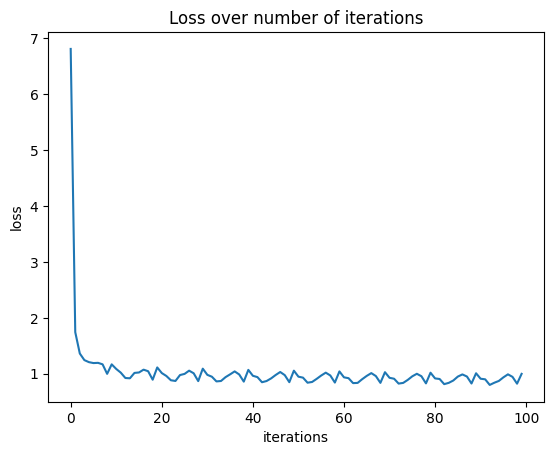

Text(0.5, 1.0, 'Loss after 10th iteration')

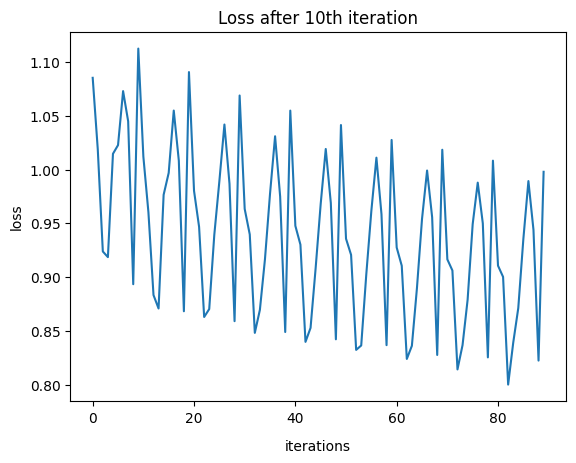

In [39]:
import matplotlib.pyplot as plt

plt.plot([np.average(np.array(l)) for l in np.array_split(np.array(loss_tab_training),100)])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss over number of iterations')
plt.show()
plt.plot([np.average(np.array(l)) for l in np.array_split(np.array(loss_tab_training),100)][10:])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss after 10th iteration')

On observe que la loss du modèle converge très rapidement et se centre autour de 1

## Test

In [29]:
loss_tab_validation=[]

for player in validation_data.index:
        current_loss=[]
        for season in validation_data.columns:
            if not(na_validation_data.loc[player,season]) and not(na_player_stats_fbref.loc[player,season]):
                # Ici on n'effectue pas la descente de gradient étant donné qu'on mesure la performance du modèle
                    input=torch.Tensor(vectorize(player,season))
                    output=torch.Tensor([validation_data.loc[player,season]])
                    prediction=model(input)
                    loss=criterion(output,prediction)
                    current_loss.append(loss)
        if current_loss!=[]:
            loss_tab_validation.append(np.average(list(map(lambda x:x.item(),current_loss))))

In [30]:
np.average(loss_tab_validation)

0.9296804205290905

Un écart quadratique moyen inférieur à 1 

sauvegarde des paramètres du modèle pour éviter de refaire la boucle d'entraînement

In [31]:
torch.save(model.state_dict(),'linear_model.pth')
!mkdir models
!mv linear_model.pth models

# Modèle:Prédiction de la performance d'un joueur suite à un transfert

## Input

### On utilise la base de données des joueurs pour donner les statistiques globales des équipes qui sera une feature du modèle

147